In [1]:
# read csv library
import pandas as pd

In [2]:
# read csv
data = pd.read_csv ('./train_E6oV3lV.csv')

In [3]:
# show data
data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
data.info()
texts = data["tweet"].tolist()
labels = data["label"].tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
# Library Applied
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
## notes: all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [7]:
# preprocessing text
texts = preprocess(texts)

In [8]:
# vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
x = vectorizer.fit_transform(texts).toarray()

In [9]:
# Make node for text and labels
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [10]:
# apply node into graph
adj = torch.tensor(np.ones((x.shape[0], x.shape[0])), dtype=torch.float32)

In [11]:
# GNN model used: GCN
class SentimentAnalysisGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = F.relu(torch.spmm(adj, self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
# Apply model and optimizer for the model used
model = SentimentAnalysisGCN(x.shape[1], 100, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

d:\Environment Deep Learning\environments\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Train the model and printing accuracy and loss
loss_fn = torch.nn.CrossEntropyLoss()
train_loss = []

for epoch in range(10):
    output = model(x, adj)
    loss = loss_fn(output, y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        _, predicted = torch.max(output, 1)
        total = len(y)
        correct = (predicted == y).sum().item()
        accuracy = correct / total
        print(f'Epoch: {epoch+1}, Accuracy: {accuracy}, Loss: {loss.item()}')

Epoch: 1, Accuracy: 0.07014579813528565, Loss: 0.693623960018158
Epoch: 2, Accuracy: 0.9298542018647143, Loss: 0.6864732503890991
Epoch: 3, Accuracy: 0.9298542018647143, Loss: 0.6793583631515503
Epoch: 4, Accuracy: 0.9298542018647143, Loss: 0.6722817420959473
Epoch: 5, Accuracy: 0.9298542018647143, Loss: 0.6652483940124512
Epoch: 6, Accuracy: 0.9298542018647143, Loss: 0.6582631468772888
Epoch: 7, Accuracy: 0.9298542018647143, Loss: 0.6513301134109497
Epoch: 8, Accuracy: 0.9298542018647143, Loss: 0.6444535255432129
Epoch: 9, Accuracy: 0.9298542018647143, Loss: 0.6376375555992126
Epoch: 10, Accuracy: 0.9298542018647143, Loss: 0.6308854222297668


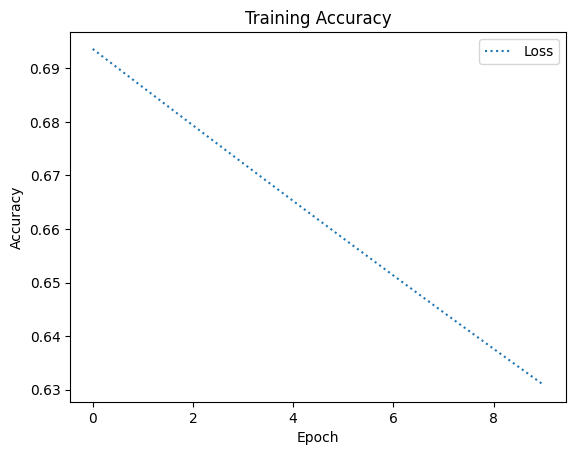

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_loss, linestyle='dotted', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()